# Final Capstone Project - Amsterdam Neighborhoods

## Step 1. Import Libraries etc.

In [1]:
import requests 
import pandas as pd 
import numpy as np 
import random 
import matplotlib.pyplot as plt
import statsmodels.api as sm

# module to convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 


from IPython.display import display_html

# tranforming json file into a pandas dataframe
from pandas.io.json import json_normalize

# plotting library
!pip install folium
import folium 

from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
from sklearn import metrics

#Matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors

     |████████████████████████████████| 93 kB 3.3 MB/s  eta 0:00:01


## Step 2: Gathering the Data and Creating the Data Tables

In [2]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

### Turning the Data found online into a Dataframe

In [3]:
data = {'Neighborhood': ['Centrum', 'Westpoort', 'Zuidoost', 'West', 'Nieuw-West', 'Oost', 'Zuid', 'Noord'],
        'Latitude': ['52.3732058', '52.4109466','52.3046538', '52.3761050', '52.3640716', '52.3498141', '52.3417212', '52.3879985'],
        'Longitude': ['4.9037116', '4.8038714', '4.9749944', '4.8645196', '4.8026762', '4.9560485', '4.8660495', '4.9176630']
        }

df = pd.DataFrame (data, columns = ['Neighborhood','Latitude', 'Longitude'])

df

,Neighborhood,Latitude,Longitude
0,Centrum,52.3732058,4.9037116
1,Westpoort,52.4109466,4.8038714
2,Zuidoost,52.3046538,4.9749944
3,West,52.3761050,4.8645196
4,Nieuw-West,52.3640716,4.8026762
5,Oost,52.3498141,4.9560485
6,Zuid,52.3417212,4.8660495
7,Noord,52.3879985,4.9176630


### Finding the Coordinates of Amsterdam and showing it on a map

In [4]:
address = "Amsterdam, NL"

geolocator = Nominatim(user_agent="Amsterdam_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Coordinates of Amsterdam are: {}, {}.'.format(latitude, longitude))



Coordinates of Amsterdam are: 52.3727598, 4.8936041.


In [5]:
map_Amsterdam = folium.Map(location=[latitude, longitude], zoom_start=12)
map_Amsterdam

### Populating the Map with Each District Datapoint

In [6]:
for lat, lng, district in zip(
        df['Latitude'], 
        df['Longitude'], 
        df['Neighborhood']):
    label = '{}'.format(district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='purple',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Amsterdam)  

map_Amsterdam

### My Foursquare Information (redacted because let's be honest I don't trust y'all with my client secret)

In [7]:
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = ''

In [8]:
neighborhood_name = df.loc[0, 'Neighborhood']
print(f"First neighborhood's name is: '{neighborhood_name}'.")

First neighborhood's name is: 'Centrum'.


### Finding the Venues in the first district (Centrum)

In [9]:
neighborhood_latitude = df.loc[0, 'Latitude']
neighborhood_longitude = df.loc[0, 'Longitude'] 

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Centrum are 52.3732058, 4.9037116.


In [10]:
LIMIT = 200 
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()

In [11]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  from ipykernel import kernelapp as app


,name,categories,lat,lng
0,Black Gold,Coffee Shop,52.371787,4.903056
1,The Hendrick's Hotel,Hotel,52.373597,4.906002
2,OCHA,Thai Restaurant,52.374024,4.901683
3,Latei,Café,52.373292,4.900279
4,Nieuwmarkt,Plaza,52.372567,4.900321
5,YoYo! Fresh Tea Bar,Tea Room,52.374065,4.900334
6,HPS,Cocktail Bar,52.371683,4.907673
7,Café 't Mandje,Gay Bar,52.374844,4.900878
8,Toko Dun Yong,Grocery Store,52.374323,4.900986
9,New King,Chinese Restaurant,52.373592,4.900284


### Finding the Venues via Foursquare with the remaining 7 Districts

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=200):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
Amsterdam_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

In [15]:
Amsterdam_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Centrum,52.3732058,4.9037116,Black Gold,52.371787,4.903056,Coffee Shop
1,Centrum,52.3732058,4.9037116,The Hendrick's Hotel,52.373597,4.906002,Hotel
2,Centrum,52.3732058,4.9037116,OCHA,52.374024,4.901683,Thai Restaurant
3,Centrum,52.3732058,4.9037116,Latei,52.373292,4.900279,Café
4,Centrum,52.3732058,4.9037116,Nieuwmarkt,52.372567,4.900321,Plaza
5,Centrum,52.3732058,4.9037116,YoYo! Fresh Tea Bar,52.374065,4.900334,Tea Room
6,Centrum,52.3732058,4.9037116,HPS,52.371683,4.907673,Cocktail Bar
7,Centrum,52.3732058,4.9037116,Café 't Mandje,52.374844,4.900878,Gay Bar
8,Centrum,52.3732058,4.9037116,Toko Dun Yong,52.374323,4.900986,Grocery Store
9,Centrum,52.3732058,4.9037116,New King,52.373592,4.900284,Chinese Restaurant


### A quick Tally of the Number of Venues found per Neighborhood

In [16]:
Amsterdam_venues.groupby('Neighborhood').count()



,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Centrum,88,88,88,88,88,88
Nieuw-West,10,10,10,10,10,10
Noord,13,13,13,13,13,13
Oost,6,6,6,6,6,6
West,17,17,17,17,17,17
Westpoort,2,2,2,2,2,2
Zuid,9,9,9,9,9,9
Zuidoost,4,4,4,4,4,4


In [17]:
print('There are {} uniques categories.'.format(len(Amsterdam_venues['Venue Category'].unique())))

There are 75 uniques categories.


### Analyzing the Neighborhoods Quickly

In [18]:
# one hot encoding
Amsterdam_onehot = pd.get_dummies(Amsterdam_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Amsterdam_onehot['Neighborhood'] = Amsterdam_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Amsterdam_onehot.columns[-1]] + list(Amsterdam_onehot.columns[:-1])
Amsterdam_onehot = Amsterdam_onehot[fixed_columns]

Amsterdam_onehot.head()

,Neighborhood,Arcade,Bagel Shop,Bakery,Bar,Baseball Field,Bed & Breakfast,Beer Bar,Bike Rental / Bike Share,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Butcher,Café,Caribbean Restaurant,Chinese Restaurant,Church,Cocktail Bar,Coffee Shop,Creperie,Deli / Bodega,Dessert Shop,Distribution Center,Electronics Store,Fabric Shop,Farm,Fish Market,French Restaurant,Gay Bar,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Heliport,History Museum,Hockey Field,Hookah Bar,Hostel,Hotel,Hotel Bar,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Malay Restaurant,Marijuana Dispensary,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Museum,Music Venue,Nightclub,Office,Park,Playground,Plaza,Pub,Rental Car Location,Restaurant,Scandinavian Restaurant,Shopping Mall,Skating Rink,Snack Place,Soccer Field,Soup Place,Supermarket,Szechuan Restaurant,Tea Room,Thai Restaurant,Theater,Turkish Restaurant,Yoga Studio
0,Centrum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Centrum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Centrum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,Centrum,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Centrum,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
Amsterdam_grouped = Amsterdam_onehot.groupby('Neighborhood').mean().reset_index()
Amsterdam_grouped



,Neighborhood,Arcade,Bagel Shop,Bakery,Bar,Baseball Field,Bed & Breakfast,Beer Bar,Bike Rental / Bike Share,Breakfast Spot,Brewery,Burger Joint,Bus Stop,Butcher,Café,Caribbean Restaurant,Chinese Restaurant,Church,Cocktail Bar,Coffee Shop,Creperie,Deli / Bodega,Dessert Shop,Distribution Center,Electronics Store,Fabric Shop,Farm,Fish Market,French Restaurant,Gay Bar,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Heliport,History Museum,Hockey Field,Hookah Bar,Hostel,Hotel,Hotel Bar,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Malay Restaurant,Marijuana Dispensary,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Museum,Music Venue,Nightclub,Office,Park,Playground,Plaza,Pub,Rental Car Location,Restaurant,Scandinavian Restaurant,Shopping Mall,Skating Rink,Snack Place,Soccer Field,Soup Place,Supermarket,Szechuan Restaurant,Tea Room,Thai Restaurant,Theater,Turkish Restaurant,Yoga Studio
0,Centrum,0.022727,0.011364,0.0,0.125000,0.0,0.011364,0.011364,0.022727,0.022727,0.022727,0.022727,0.000000,0.011364,0.034091,0.000000,0.022727,0.022727,0.022727,0.068182,0.022727,0.011364,0.022727,0.000000,0.000000,0.011364,0.00,0.0,0.022727,0.011364,0.000000,0.011364,0.0,0.011364,0.00,0.0,0.011364,0.000000,0.000000,0.034091,0.068182,0.011364,0.011364,0.011364,0.022727,0.011364,0.011364,0.022727,0.000000,0.022727,0.011364,0.011364,0.000000,0.022727,0.011364,0.000000,0.000000,0.000000,0.000000,0.011364,0.045455,0.000000,0.011364,0.000000,0.000000,0.000000,0.000000,0.0,0.011364,0.000000,0.011364,0.011364,0.022727,0.0,0.000000,0.000000
1,Nieuw-West,0.000000,0.000000,0.1,0.000000,0.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.1,0.000000,0.000000,0.000000,0.000000,0.1,0.100000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.000000,0.100000,0.000000,0.000000,0.000000,0.1,0.000000,0.000000
2,Noord,0.000000,0.000000,0.0,0.000000,0.0,0.076923,0.000000,0.000000,0.000000,0.076923,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.076923,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.076923,0.000000,0.153846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.076923,0.000000,0.000000,0.000000,0.0,0.076923,0.076923
3,Oost,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
4,West,0.000000,0.058824,0.0,0.058824,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.058824,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.00,0.0,0.000000,0.000000,0.058824,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,

### Finding the Most Common Venue Types per District

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Amsterdam_grouped['Neighborhood']

for ind in np.arange(Amsterdam_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Amsterdam_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Centrum,Bar,Hotel,Coffee Shop
1,Nieuw-West,Soccer Field,Theater,Gym / Fitness Center
2,Noord,Plaza,Yoga Studio,Bed & Breakfast
3,Oost,Soccer Field,Hockey Field,Playground
4,West,Nightclub,Snack Place,Supermarket
5,Westpoort,Heliport,Harbor / Marina,Yoga Studio
6,Zuid,Bagel Shop,Office,Supermarket
7,Zuidoost,Farm,Harbor / Marina,Park


### Adding the Number of Venues to our Original Dataframe

In [21]:
venuesnumber = [88, 2, 4, 17, 10, 6, 9, 13]
df['Venues'] = venuesnumber

In [22]:
df

,Neighborhood,Latitude,Longitude,Venues
0,Centrum,52.3732058,4.9037116,88
1,Westpoort,52.4109466,4.8038714,2
2,Zuidoost,52.3046538,4.9749944,4
3,West,52.3761050,4.8645196,17
4,Nieuw-West,52.3640716,4.8026762,10
5,Oost,52.3498141,4.9560485,6
6,Zuid,52.3417212,4.8660495,9
7,Noord,52.3879985,4.9176630,13


### Adding Density and Safety to our Dataframe

In [23]:
pop = [13748, 10, 4391, 15252, 4478, 7635, 9349, 2269]
df['Population Density'] = pop

In [24]:
safety = [69, 0, 132, 79, 130, 80, 56, 112]
df['Safety Index'] = safety

In [25]:
Safe = [1, 1, 0, 1, 0, 1, 1, 0]
df['Safe'] = Safe

In [26]:
df

,Neighborhood,Latitude,Longitude,Venues,Population Density,Safety Index,Safe
0,Centrum,52.3732058,4.9037116,88,13748,69,1
1,Westpoort,52.4109466,4.8038714,2,10,0,1
2,Zuidoost,52.3046538,4.9749944,4,4391,132,0
3,West,52.3761050,4.8645196,17,15252,79,1
4,Nieuw-West,52.3640716,4.8026762,10,4478,130,0
5,Oost,52.3498141,4.9560485,6,7635,80,1
6,Zuid,52.3417212,4.8660495,9,9349,56,1
7,Noord,52.3879985,4.9176630,13,2269,112,0


## Step 3: Analyzing the Data

### Scatterplots:

#### Population Density vs Venues

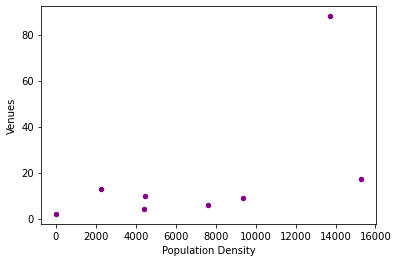

In [27]:
Splot1 = df.plot.scatter(x='Population Density',

                      y='Venues',

                      c='Purple')

#### Population Density vs Safety Index

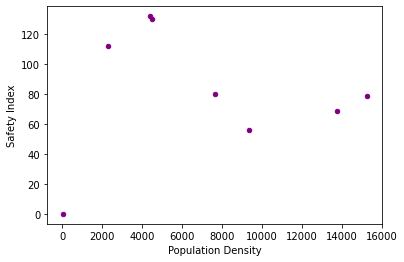

In [28]:
Splot2 = df.plot.scatter(x='Population Density',

                      y='Safety Index',

                      c='Purple')

#### Venues vs Safety Index

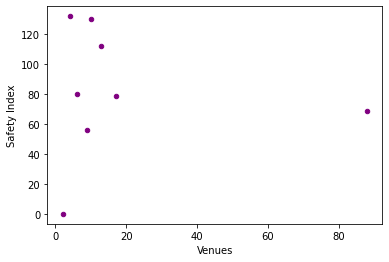

In [29]:
Splot3 = df.plot.scatter(x='Venues',

                      y='Safety Index',

                      c='Purple')

### Bar Charts:

#### Population Density

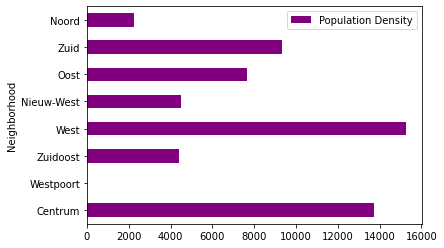

In [30]:
BarChart1 = df.plot.barh(x='Neighborhood', y='Population Density', rot=0, color='Purple')

#### Venues

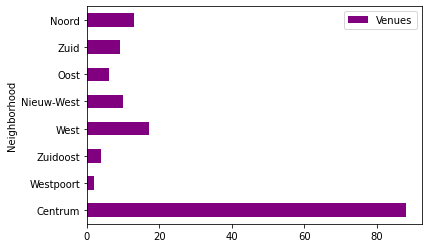

In [31]:
BarChart2 = df.plot.barh(x='Neighborhood', y='Venues', rot=0, color='Purple')

#### Safety Index

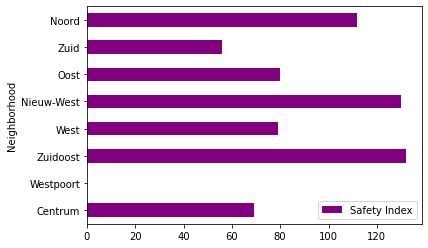

In [32]:
BarChart3 = df.plot.barh(x='Neighborhood', y='Safety Index', rot=0, color='Purple')

### K Nearest Neighbor:

#### Setting up KNN & Testing out a Value of K=4

In [33]:
X = df.drop(['Neighborhood', 'Latitude', 'Longitude', 'Safety Index', 'Safe'], axis = 1)
y = df['Safe']
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
#Train Model and Predict
k = 4  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
Pred_y = neigh.predict(X_test)
print("Accuracy of model at K=4 is",metrics.accuracy_score(y_test, Pred_y))

Accuracy of model at K=4 is 0.0


#### Finding the Value of K at which the Error Rate is Lowest

Minimum error:- 0.0 at K = 0


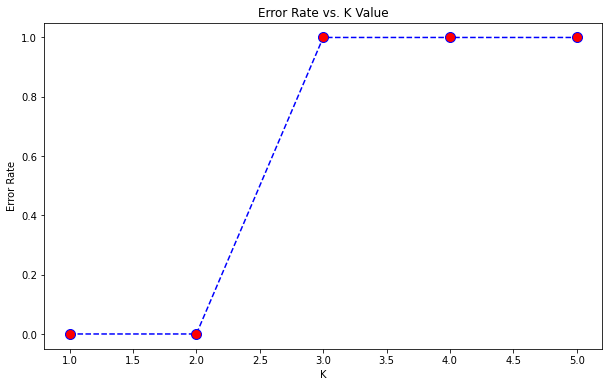

In [34]:
error_rate = []
for i in range(1,6):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,y_train)
 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,6),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

#### Finding the Value of K for which Accuracy is Highest

Maximum accuracy:- 1.0 at K = 0


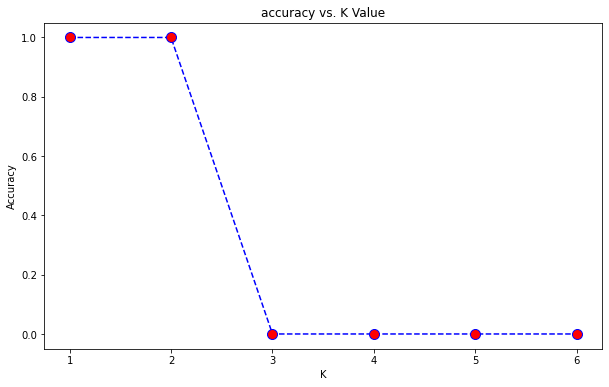

In [35]:
acc = []

from sklearn import metrics
for i in range(1,7):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,7),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

#### Clustering the Neighborhoods Using a Value of K=2

In [36]:
# set number of clusters
kclusters = 2

Amsterdam_grouped_clustering = Amsterdam_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Amsterdam_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]



array([1, 1, 1, 1, 1, 0, 1, 1], dtype=int32)

#### Adding the Cluster Label to the Dataframe

In [37]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster labels', kmeans.labels_)

Amsterdam_merged = df

Amsterdam_merged = Amsterdam_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [38]:
Amsterdam_merged

,Neighborhood,Latitude,Longitude,Venues,Population Density,Safety Index,Safe,Cluster labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Centrum,52.3732058,4.9037116,88,13748,69,1,1,Bar,Hotel,Coffee Shop
1,Westpoort,52.4109466,4.8038714,2,10,0,1,0,Heliport,Harbor / Marina,Yoga Studio
2,Zuidoost,52.3046538,4.9749944,4,4391,132,0,1,Farm,Harbor / Marina,Park
3,West,52.3761050,4.8645196,17,15252,79,1,1,Nightclub,Snack Place,Supermarket
4,Nieuw-West,52.3640716,4.8026762,10,4478,130,0,1,Soccer Field,Theater,Gym / Fitness Center
5,Oost,52.3498141,4.9560485,6,7635,80,1,1,Soccer Field,Hockey Field,Playground
6,Zuid,52.3417212,4.8660495,9,9349,56,1,1,Bagel Shop,Office,Supermarket
7,Noord,52.3879985,4.9176630,13,2269,112,0,1,Plaza,Yoga Studio,Bed & Breakfast


#### Visually Representing the Clustered Neighborhoods

In [39]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        Amsterdam_merged['Latitude'], 
        Amsterdam_merged['Longitude'], 
        Amsterdam_merged['Neighborhood'], 
        Amsterdam_merged['Cluster labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Regression:

In [40]:
X = df[['Population Density','Venues']]  
Y = df['Safety Index']

X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:           Safety Index   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.390
Method:                 Least Squares   F-statistic:                   0.01747
Date:                Sat, 14 Nov 2020   Prob (F-statistic):              0.983
Time:                        07:47:51   Log-Likelihood:                -40.984
No. Observations:                   8   AIC:                             87.97
Df Residuals:                       5   BIC:                             88.21
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 81.5631     31

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/scipy/stats/stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  "anyway, n=%i" % int(n))
